# 🛡️ CICIDS2017 Intrusion Detection System (IDS) - Binary Classification

## Detecting BENIGN vs ATTACK Traffic

---

### Table of Contents
1. [Importing Libraries](#1)
2. [Data Pre-processing](#2)
3. [Data Exploring](#3)
4. [Data Splitting (70% Train, 15% Validation, 15% Test)](#4)
5. [Model Training](#5)
6. [Model Evaluation](#6)
7. [Model Comparison](#7)

## 1. Importing Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import warnings
import time
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Model saving
import pickle

print('✓ All libraries imported!')
print(f'Time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')


✓ All libraries imported!
Time: 2025-12-09 00:30:13


## 2. Data Pre-processing

### 2.1 Load Data

In [2]:
print('='*70)
print('LOADING CICIDS2017 DATASET')
print('='*70)

# Load CSV files
data_folder = 'data/'
csv_files = glob.glob(data_folder + '*.csv')

if len(csv_files) == 0:
    print(f'⚠️  No CSV files found in {data_folder}')
    print('Please place CICIDS2017 CSV files in the data/ folder.')
else:
    print(f'✓ Found {len(csv_files)} CSV files')
    
    df_list = []
    for file in csv_files:
        print(f'  Loading: {os.path.basename(file)}...')
        df_temp = pd.read_csv(file)
        df_list.append(df_temp)
    
    df = pd.concat(df_list, ignore_index=True)
    print(f'\n✓ Total rows: {len(df):,}')
    print(f'✓ Total columns: {len(df.columns)}')

LOADING CICIDS2017 DATASET
✓ Found 5 CSV files
  Loading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
  Loading: Monday-WorkingHours.pcap_ISCX.csv...
  Loading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
  Loading: Tuesday-WorkingHours.pcap_ISCX.csv...
  Loading: Wednesday-workingHours.pcap_ISCX.csv...

✓ Total rows: 2,064,641
✓ Total columns: 79


### 2.2 Clean Column Names

In [3]:
# Strip spaces from column names
df.columns = df.columns.str.strip()
print('✓ Column names cleaned!')
print(f'First 5 columns: {list(df.columns[:5])}')

✓ Column names cleaned!
First 5 columns: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets']


### 2.3 Handle Missing Values and NaN

In [4]:
print('\nHandling missing values...')

# Replace infinity with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Count missing values
missing_count = df.isnull().sum().sum()
print(f'Total missing/NaN values: {missing_count:,}')

if missing_count > 0:
    # Show columns with most missing values
    missing_cols = df.isnull().sum()
    missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)
    print(f'\nTop 5 columns with missing values:')
    for col, count in missing_cols.head(5).items():
        pct = (count / len(df)) * 100
        print(f'  {col:40s}: {count:,} ({pct:.2f}%)')
    
    # Remove rows with NaN
    rows_before = len(df)
    df = df.dropna()
    rows_after = len(df)
    print(f'\n✓ Removed {rows_before - rows_after:,} rows with NaN')
    print(f'✓ Remaining rows: {rows_after:,}')
else:
    print('✓ No missing values!')


Handling missing values...
Total missing/NaN values: 4,334

Top 5 columns with missing values:
  Flow Bytes/s                            : 2,167 (0.10%)
  Flow Packets/s                          : 2,167 (0.10%)

✓ Removed 2,167 rows with NaN
✓ Remaining rows: 2,062,474


### 2.4 Create Binary Labels (BENIGN vs ATTACK)

In [5]:
print('\nCreating binary labels...')

# Show original distribution
print('Original labels:')
print(df['Label'].value_counts().head(10))

# Create binary labels
df['Binary_Label'] = df['Label'].apply(
    lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK'
)

print('\nBinary labels:')
print(df['Binary_Label'].value_counts())


Creating binary labels...
Original labels:
Label
BENIGN                      1666714
DoS Hulk                     230124
DDoS                         128025
DoS GoldenEye                 10293
FTP-Patator                    7935
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Web Attack � Brute Force       1507
Web Attack � XSS                652
Name: count, dtype: int64

Binary labels:
Binary_Label
BENIGN    1666714
ATTACK     395760
Name: count, dtype: int64


### 2.5 Balance Classes

In [6]:
print('\nBalancing classes...')

df_benign = df[df['Binary_Label'] == 'BENIGN'].copy()
df_attack = df[df['Binary_Label'] == 'ATTACK'].copy()

print(f'Before: BENIGN={len(df_benign):,}, ATTACK={len(df_attack):,}')

# Undersample majority class
if len(df_benign) > len(df_attack):
    df_benign_balanced = resample(df_benign, n_samples=len(df_attack), 
                                   random_state=42, replace=False)
    df_attack_balanced = df_attack
else:
    df_attack_balanced = resample(df_attack, n_samples=len(df_benign),
                                   random_state=42, replace=False)
    df_benign_balanced = df_benign

# Combine and shuffle
df_balanced = pd.concat([df_benign_balanced, df_attack_balanced])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f'After:  BENIGN={len(df_benign_balanced):,}, ATTACK={len(df_attack_balanced):,}')
print(f'Total: {len(df_balanced):,}')
print('✓ Classes balanced 1:1!')


Balancing classes...
Before: BENIGN=1,666,714, ATTACK=395,760
After:  BENIGN=395,760, ATTACK=395,760
Total: 791,520
✓ Classes balanced 1:1!


## 3. Data Exploring

### 3.1 Dataset Overview

In [7]:
print('Dataset shape:', df_balanced.shape)
print(f'Rows: {df_balanced.shape[0]:,}')
print(f'Columns: {df_balanced.shape[1]}')
print(f'\nMemory: {df_balanced.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

Dataset shape: (791520, 80)
Rows: 791,520
Columns: 80

Memory: 566.69 MB


### 3.2 Label Distribution Visualization

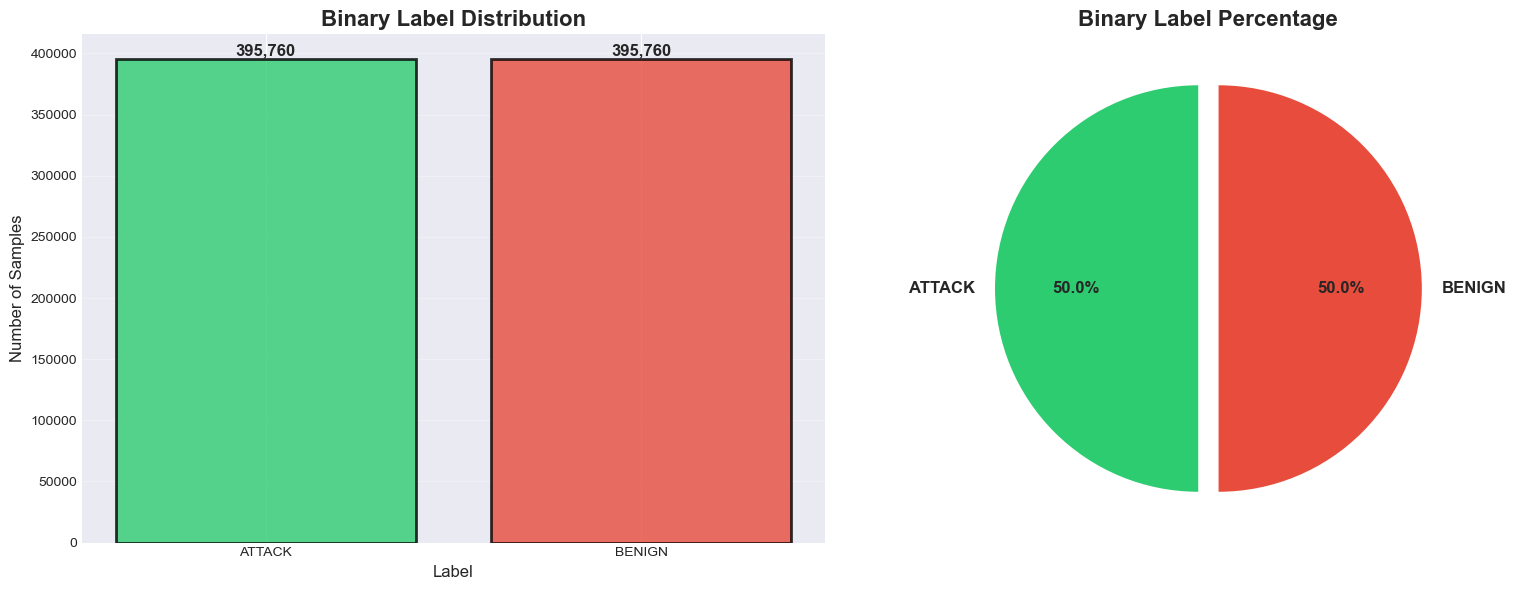

✓ Saved: binary_label_distribution.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
ax1 = axes[0]
label_counts = df_balanced['Binary_Label'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(label_counts.index, label_counts.values, color=colors,
               edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_title('Binary Label Distribution', fontsize=16, fontweight='bold')
ax1.set_xlabel('Label', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, explode=(0.05, 0.05),
        textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Binary Label Percentage', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('binary_label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print('✓ Saved: binary_label_distribution.png')

### 3.3 Feature Statistics

In [9]:
numeric_cols = df_balanced.select_dtypes(include=[np.number]).columns
print(f'Number of numeric features: {len(numeric_cols)}')
print('\nBasic statistics (first 5 features):')
print(df_balanced[numeric_cols[:5]].describe())

Number of numeric features: 78

Basic statistics (first 5 features):
       Destination Port  Flow Duration  Total Fwd Packets  \
count     791520.000000   7.915200e+05      791520.000000   
mean        5083.707046   2.636858e+07           7.776841   
std        15352.560928   4.114308e+07         565.271992   
min            0.000000  -1.000000e+00           1.000000   
25%           80.000000   3.790000e+02           2.000000   
50%           80.000000   2.251485e+05           3.000000   
75%           80.000000   6.709389e+07           7.000000   
max        65534.000000   1.200000e+08      219759.000000   

       Total Backward Packets  Total Length of Fwd Packets  
count           791520.000000                 7.915200e+05  
mean                 7.912850                 4.466128e+02  
std                753.881697                 4.464976e+03  
min                  0.000000                 0.000000e+00  
25%                  1.000000                 2.400000e+01  
50%            

### 3.4 Correlation Heatmap

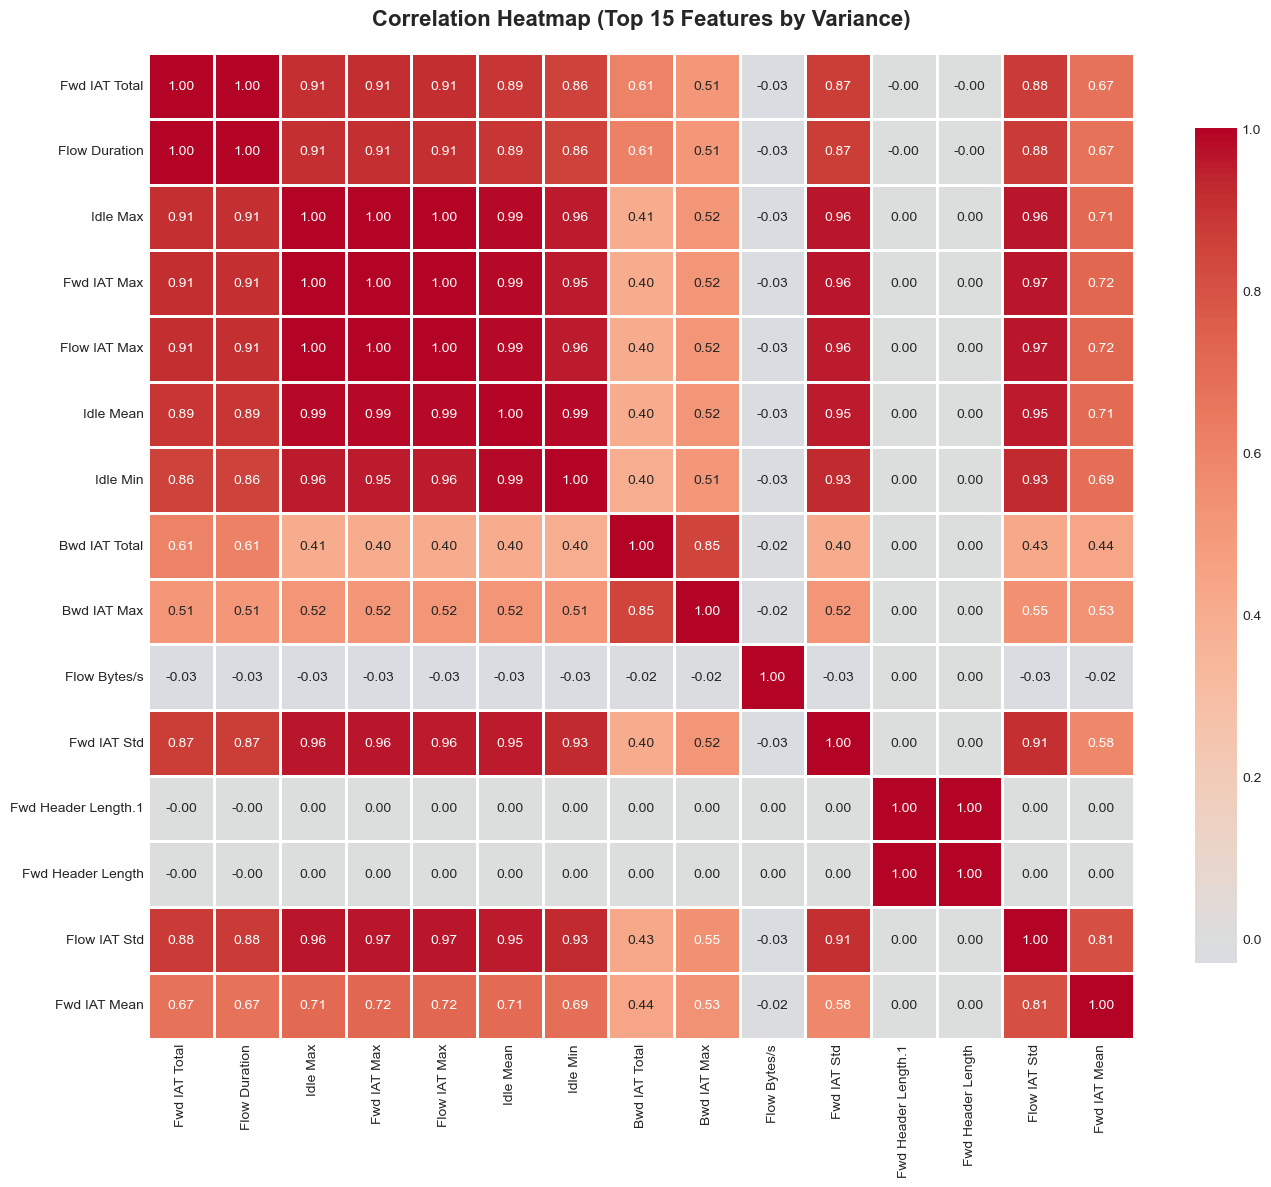

✓ Saved: correlation_heatmap.png


In [10]:
# Select top 15 features by variance
numeric_data = df_balanced.select_dtypes(include=[np.number])
variances = numeric_data.var().sort_values(ascending=False)
top_features = variances.head(15).index.tolist()

correlation_matrix = df_balanced[top_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap (Top 15 Features by Variance)',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print('✓ Saved: correlation_heatmap.png')

## 4. Data Splitting (70% Train, 15% Validation, 15% Test)

### 4.1 Prepare Features and Labels

In [11]:
# Separate features and labels
X = df_balanced.drop(['Label', 'Binary_Label'], axis=1)
y = df_balanced['Binary_Label']

print(f'Features shape: {X.shape}')
print(f'Labels shape: {y.shape}')

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f'\nLabel encoding:')
for i, label in enumerate(label_encoder.classes_):
    print(f'  {i}: {label}')

Features shape: (791520, 78)
Labels shape: (791520,)

Label encoding:
  0: ATTACK
  1: BENIGN


### 4.2 Split Data

In [12]:
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

# Second split: 50% of temp for val, 50% for test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f'✓ Data split completed:')
print(f'  Training:   {len(X_train):7,} samples ({len(X_train)/len(X)*100:5.1f}%)')
print(f'  Validation: {len(X_val):7,} samples ({len(X_val)/len(X)*100:5.1f}%)')
print(f'  Test:       {len(X_test):7,} samples ({len(X_test)/len(X)*100:5.1f}%)')

✓ Data split completed:
  Training:   554,064 samples ( 70.0%)
  Validation: 118,728 samples ( 15.0%)
  Test:       118,728 samples ( 15.0%)


### 4.3 Visualize Split Distribution

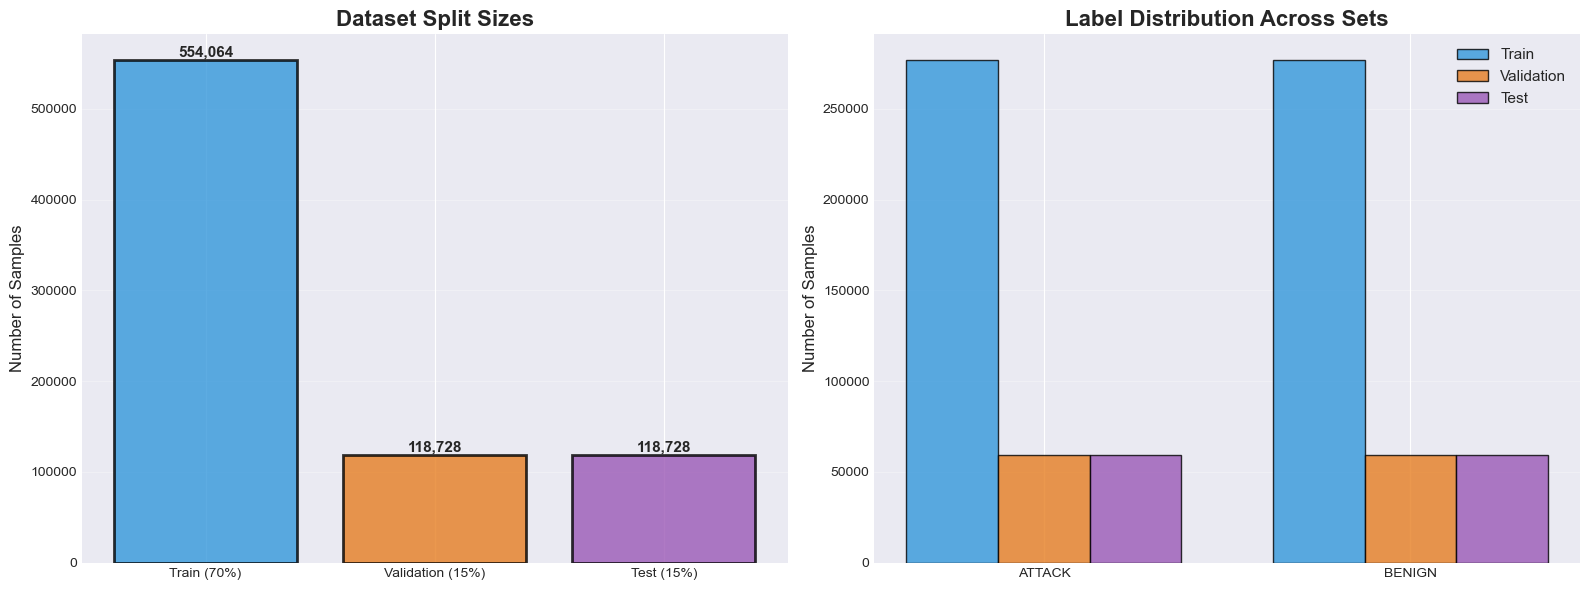

✓ Saved: data_split_visualization.png


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dataset sizes
ax1 = axes[0]
sizes = [len(X_train), len(X_val), len(X_test)]
labels_split = ['Train (70%)', 'Validation (15%)', 'Test (15%)']
colors_split = ['#3498db', '#e67e22', '#9b59b6']

bars = ax1.bar(labels_split, sizes, color=colors_split, edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_title('Dataset Split Sizes', fontsize=16, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Label distribution
ax2 = axes[1]
train_dist = [sum(y_train==0), sum(y_train==1)]
val_dist = [sum(y_val==0), sum(y_val==1)]
test_dist = [sum(y_test==0), sum(y_test==1)]

x_pos = np.arange(2)
width = 0.25

ax2.bar(x_pos - width, train_dist, width, label='Train', color='#3498db', edgecolor='black', alpha=0.8)
ax2.bar(x_pos, val_dist, width, label='Validation', color='#e67e22', edgecolor='black', alpha=0.8)
ax2.bar(x_pos + width, test_dist, width, label='Test', color='#9b59b6', edgecolor='black', alpha=0.8)

ax2.set_title('Label Distribution Across Sets', fontsize=16, fontweight='bold')
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['ATTACK', 'BENIGN'])
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('data_split_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print('✓ Saved: data_split_visualization.png')

## 5. Model Training

### 5.1 Setup

In [14]:
# Create folder for models
model_folder = 'new_models'
os.makedirs(model_folder, exist_ok=True)
print(f'✓ Model folder created: {model_folder}/')

# Store results
model_results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

✓ Model folder created: new_models/


### 5.2 Random Forest

#### 5.2.1 Train Model

In [15]:
print('='*70)
print('TRAINING RANDOM FOREST')
print('='*70)

start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print('Training...')
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f'✓ Training completed in {training_time:.2f} seconds')

TRAINING RANDOM FOREST
Training...
✓ Training completed in 73.86 seconds


#### 5.2.2 Cross-Validation

In [39]:
from sklearn.model_selection import StratifiedKFold, cross_validate

print('Performing 5-fold cross-validation...')

# Use StratifiedKFold for balanced splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# FIXED: Use dictionary with weighted metrics
rf_cv_results = cross_validate(
    rf_model, X_train, y_train, 
    cv=cv,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',  # Changed from 'precision'
        'recall': 'recall_weighted',        # Changed from 'recall'
        'f1': 'f1_weighted'                 # Changed from 'f1'
    },
    n_jobs=-1
)

# Print results
print(f'CV Accuracy:  {rf_cv_results["test_accuracy"].mean():.4f} (+/- {rf_cv_results["test_accuracy"].std():.4f})')
print(f'CV Precision: {rf_cv_results["test_precision"].mean():.4f} (+/- {rf_cv_results["test_precision"].std():.4f})')
print(f'CV Recall:    {rf_cv_results["test_recall"].mean():.4f} (+/- {rf_cv_results["test_recall"].std():.4f})')
print(f'CV F1 Score:  {rf_cv_results["test_f1"].mean():.4f} (+/- {rf_cv_results["test_f1"].std():.4f})')

Performing 5-fold cross-validation...
CV Accuracy:  0.9995 (+/- 0.0001)
CV Precision: 0.9995 (+/- 0.0001)
CV Recall:    0.9995 (+/- 0.0001)
CV F1 Score:  0.9995 (+/- 0.0001)


#### 5.2.3 Predictions and Evaluation

In [17]:
# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)

# Metrics
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_val_acc = accuracy_score(y_val, rf_val_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

rf_train_f1 = f1_score(y_train, rf_train_pred, average='weighted')
rf_val_f1 = f1_score(y_val, rf_val_pred, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_pred, average='weighted')

print(f'Performance:')
print(f'  Train - Acc: {rf_train_acc:.4f}, F1: {rf_train_f1:.4f}')
print(f'  Val   - Acc: {rf_val_acc:.4f}, F1: {rf_val_f1:.4f}')
print(f'  Test  - Acc: {rf_test_acc:.4f}, F1: {rf_test_f1:.4f}')

# Store results
model_results.append({
    'model': 'Random Forest',
    'train_acc': rf_train_acc, 'val_acc': rf_val_acc, 'test_acc': rf_test_acc,
    'train_f1': rf_train_f1, 'val_f1': rf_val_f1, 'test_f1': rf_test_f1,
    'cv_acc_mean': rf_cv_results['test_accuracy'].mean(),
    'cv_acc_std': rf_cv_results['test_accuracy'].std(),
    'training_time': training_time
})

Performance:
  Train - Acc: 0.9998, F1: 0.9998
  Val   - Acc: 0.9995, F1: 0.9995
  Test  - Acc: 0.9996, F1: 0.9996


#### 5.2.4 Feature Importance Visualization

Top 10 Important Features:
               feature  importance
      Destination Port    0.085620
   Average Packet Size    0.063501
 Bwd Packet Length Std    0.055121
 Bwd Packet Length Max    0.051940
  Avg Bwd Segment Size    0.049299
     Max Packet Length    0.042355
Bwd Packet Length Mean    0.041088
         Bwd Packets/s    0.038714
Packet Length Variance    0.034702
     Packet Length Std    0.031841


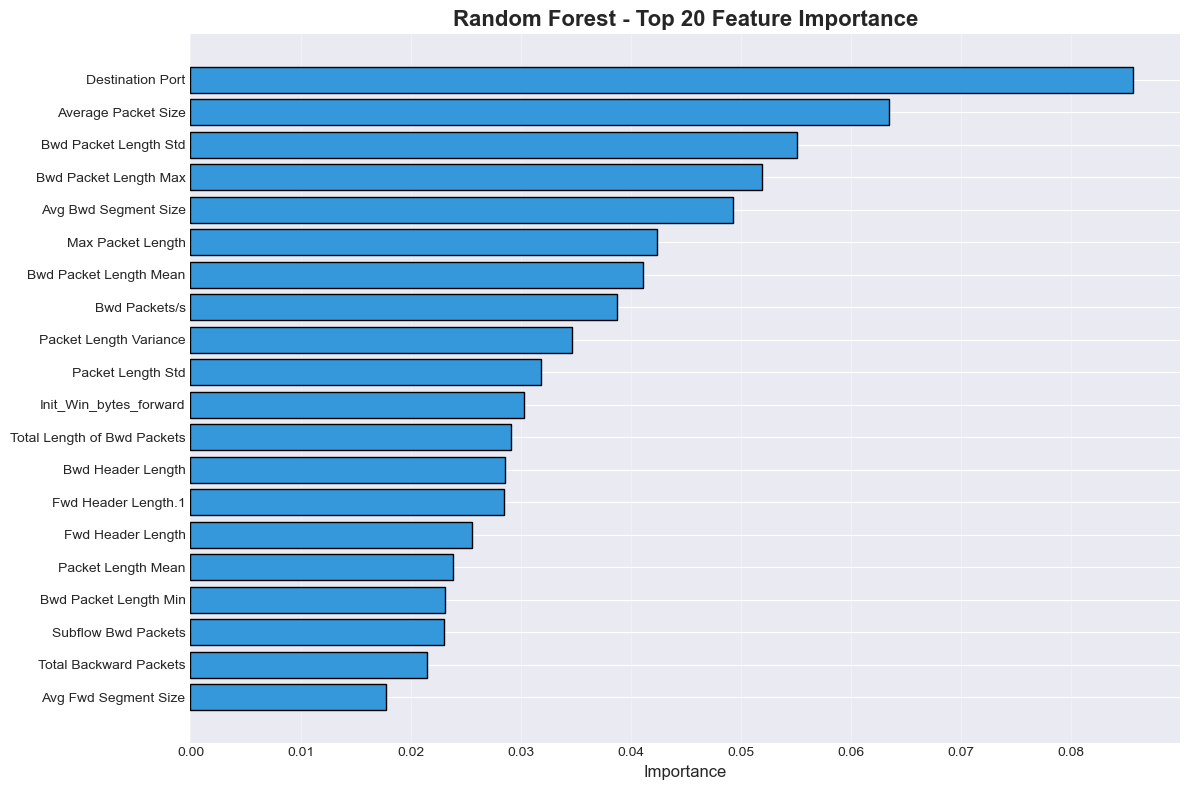

✓ Saved: rf_feature_importance.png


In [18]:
# Get feature importance
rf_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('Top 10 Important Features:')
print(rf_feature_importance.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_20 = rf_feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'].values, color='#3498db', edgecolor='black')
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.title('Random Forest - Top 20 Feature Importance', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print('✓ Saved: rf_feature_importance.png')

#### 5.2.5 Save Model

In [19]:
rf_package = {
    'model': rf_model,
    'model_name': 'Random Forest Binary Classifier',
    'scaler': None,
    'label_encoder': label_encoder,
    'label_names': label_encoder.classes_.tolist(),
    'feature_names': X.columns.tolist(),
    'test_accuracy': rf_test_acc,
    'test_f1': rf_test_f1,
    'scaling_required': False,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'binary',
    'cv_results': rf_cv_results
}

with open(f'{model_folder}/random_forest_binary.pkl', 'wb') as f:
    pickle.dump(rf_package, f)

print(f'✓ Saved: {model_folder}/random_forest_binary.pkl')

✓ Saved: new_models/random_forest_binary.pkl


### 5.3 Logistic Regression

#### 5.3.1 Scale Features

In [20]:
# Scale features (required for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print('✓ Features scaled')

✓ Features scaled


#### 5.3.2 Train Model

In [21]:
print('='*70)
print('TRAINING LOGISTIC REGRESSION')
print('='*70)

start_time = time.time()

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='saga',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print('Training...')
lr_model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

print(f'✓ Training completed in {training_time:.2f} seconds')

TRAINING LOGISTIC REGRESSION
Training...
✓ Training completed in 991.45 seconds


#### 5.3.3 Cross-Validation

In [22]:
print('Performing 5-fold cross-validation...')
lr_cv_results = cross_validate(
    lr_model, X_train_scaled, y_train, cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    n_jobs=-1
)

print(f'CV Accuracy: {lr_cv_results["test_accuracy"].mean():.4f} (+/- {lr_cv_results["test_accuracy"].std():.4f})')
print(f'CV F1 Score: {lr_cv_results["test_f1"].mean():.4f} (+/- {lr_cv_results["test_f1"].std():.4f})')

Performing 5-fold cross-validation...
CV Accuracy: 0.9404 (+/- 0.0008)
CV F1 Score: 0.9398 (+/- 0.0009)


#### 5.3.4 Predictions and Evaluation

In [23]:
# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_val_pred = lr_model.predict(X_val_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)
lr_test_proba = lr_model.predict_proba(X_test_scaled)

# Metrics
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_val_acc = accuracy_score(y_val, lr_val_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

lr_train_f1 = f1_score(y_train, lr_train_pred, average='weighted')
lr_val_f1 = f1_score(y_val, lr_val_pred, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_pred, average='weighted')

print(f'Performance:')
print(f'  Train - Acc: {lr_train_acc:.4f}, F1: {lr_train_f1:.4f}')
print(f'  Val   - Acc: {lr_val_acc:.4f}, F1: {lr_val_f1:.4f}')
print(f'  Test  - Acc: {lr_test_acc:.4f}, F1: {lr_test_f1:.4f}')

# Store results
model_results.append({
    'model': 'Logistic Regression',
    'train_acc': lr_train_acc, 'val_acc': lr_val_acc, 'test_acc': lr_test_acc,
    'train_f1': lr_train_f1, 'val_f1': lr_val_f1, 'test_f1': lr_test_f1,
    'cv_acc_mean': lr_cv_results['test_accuracy'].mean(),
    'cv_acc_std': lr_cv_results['test_accuracy'].std(),
    'training_time': training_time
})

Performance:
  Train - Acc: 0.9408, F1: 0.9408
  Val   - Acc: 0.9408, F1: 0.9408
  Test  - Acc: 0.9405, F1: 0.9405


#### 5.3.5 Feature Coefficients Visualization

Top 10 Important Features (by coefficient):
               feature  coefficient
      Destination Port     2.973525
Packet Length Variance    -2.301148
 Bwd Packet Length Min     2.222528
        ACK Flag Count    -1.847539
 Fwd Packet Length Max     1.200706
 Fwd Packet Length Std     1.141809
         Bwd IAT Total     1.002328
        PSH Flag Count    -0.953102
 Bwd Packet Length Std    -0.848870
         Flow IAT Mean    -0.820256


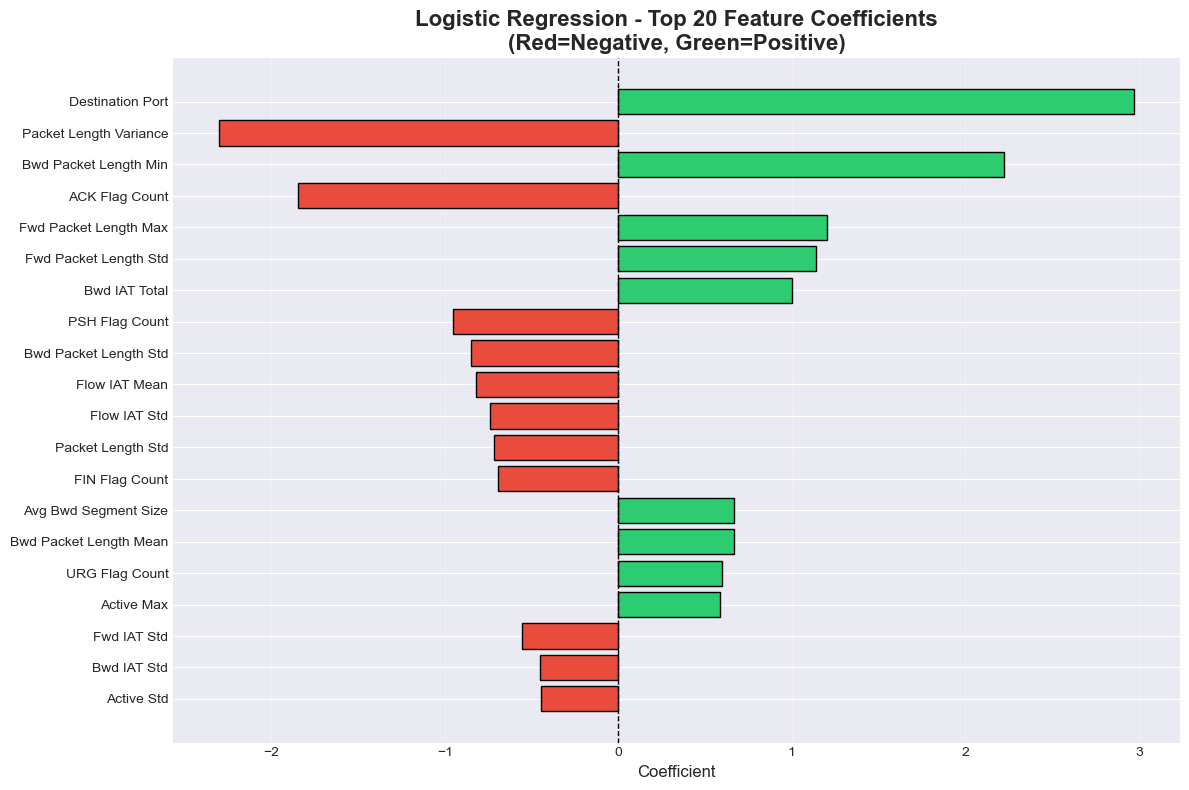

✓ Saved: lr_feature_coefficients.png


In [24]:
# Get coefficients
lr_coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print('Top 10 Important Features (by coefficient):')
print(lr_coefficients.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_20 = lr_coefficients.head(20)
colors_lr = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_20['coefficient']]
plt.barh(range(len(top_20)), top_20['coefficient'].values, color=colors_lr, edgecolor='black')
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Coefficient', fontsize=12)
plt.title('Logistic Regression - Top 20 Feature Coefficients\n(Red=Negative, Green=Positive)',
          fontsize=16, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('lr_feature_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()
print('✓ Saved: lr_feature_coefficients.png')

#### 5.3.6 Save Model

In [25]:
lr_package = {
    'model': lr_model,
    'model_name': 'Logistic Regression Binary Classifier',
    'scaler': scaler,
    'label_encoder': label_encoder,
    'label_names': label_encoder.classes_.tolist(),
    'feature_names': X.columns.tolist(),
    'test_accuracy': lr_test_acc,
    'test_f1': lr_test_f1,
    'scaling_required': True,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'binary',
    'cv_results': lr_cv_results
}

with open(f'{model_folder}/logistic_regression_binary.pkl', 'wb') as f:
    pickle.dump(lr_package, f)

print(f'✓ Saved: {model_folder}/logistic_regression_binary.pkl')

✓ Saved: new_models/logistic_regression_binary.pkl


### 5.4 Neural Network

#### 5.4.1 Train Model

In [26]:
print('='*70)
print('TRAINING NEURAL NETWORK')
print('='*70)

# Calculate sample weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}
# Note: Shown for reference - MLPClassifier doesn't accept sample_weight parameter
# Class imbalance is handled through our balanced dataset


print(f'Class weights: {class_weights_dict}')

start_time = time.time()

nn_model = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=256,
    learning_rate='adaptive',
    max_iter=200,
    random_state=42,
    verbose=False,
    early_stopping=True,
    validation_fraction=0.1
)

print('Training...')
nn_model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

print(f'✓ Training completed in {training_time:.2f} seconds')
print(f'  Iterations: {nn_model.n_iter_}')
print(f'  Final loss: {nn_model.loss_:.6f}')

TRAINING NEURAL NETWORK
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Training...
✓ Training completed in 311.61 seconds
  Iterations: 34
  Final loss: 0.018745


#### 5.4.2 Cross-Validation

In [27]:
print('Performing 5-fold cross-validation (simplified model for speed)...')
nn_cv_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    max_iter=100,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

nn_cv_results = cross_validate(
    nn_cv_model, X_train_scaled, y_train, cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    n_jobs=-1
)

print(f'CV Accuracy: {nn_cv_results["test_accuracy"].mean():.4f} (+/- {nn_cv_results["test_accuracy"].std():.4f})')
print(f'CV F1 Score: {nn_cv_results["test_f1"].mean():.4f} (+/- {nn_cv_results["test_f1"].std():.4f})')

Performing 5-fold cross-validation (simplified model for speed)...
CV Accuracy: 0.9943 (+/- 0.0010)
CV F1 Score: 0.9943 (+/- 0.0010)


#### 5.4.3 Predictions and Evaluation

In [28]:
# Predictions
nn_train_pred = nn_model.predict(X_train_scaled)
nn_val_pred = nn_model.predict(X_val_scaled)
nn_test_pred = nn_model.predict(X_test_scaled)
nn_test_proba = nn_model.predict_proba(X_test_scaled)

# Metrics
nn_train_acc = accuracy_score(y_train, nn_train_pred)
nn_val_acc = accuracy_score(y_val, nn_val_pred)
nn_test_acc = accuracy_score(y_test, nn_test_pred)

nn_train_f1 = f1_score(y_train, nn_train_pred, average='weighted')
nn_val_f1 = f1_score(y_val, nn_val_pred, average='weighted')
nn_test_f1 = f1_score(y_test, nn_test_pred, average='weighted')

print(f'Performance:')
print(f'  Train - Acc: {nn_train_acc:.4f}, F1: {nn_train_f1:.4f}')
print(f'  Val   - Acc: {nn_val_acc:.4f}, F1: {nn_val_f1:.4f}')
print(f'  Test  - Acc: {nn_test_acc:.4f}, F1: {nn_test_f1:.4f}')

# Store results
model_results.append({
    'model': 'Neural Network',
    'train_acc': nn_train_acc, 'val_acc': nn_val_acc, 'test_acc': nn_test_acc,
    'train_f1': nn_train_f1, 'val_f1': nn_val_f1, 'test_f1': nn_test_f1,
    'cv_acc_mean': nn_cv_results['test_accuracy'].mean(),
    'cv_acc_std': nn_cv_results['test_accuracy'].std(),
    'training_time': training_time
})

Performance:
  Train - Acc: 0.9945, F1: 0.9945
  Val   - Acc: 0.9940, F1: 0.9940
  Test  - Acc: 0.9946, F1: 0.9946


#### 5.4.4 Training History

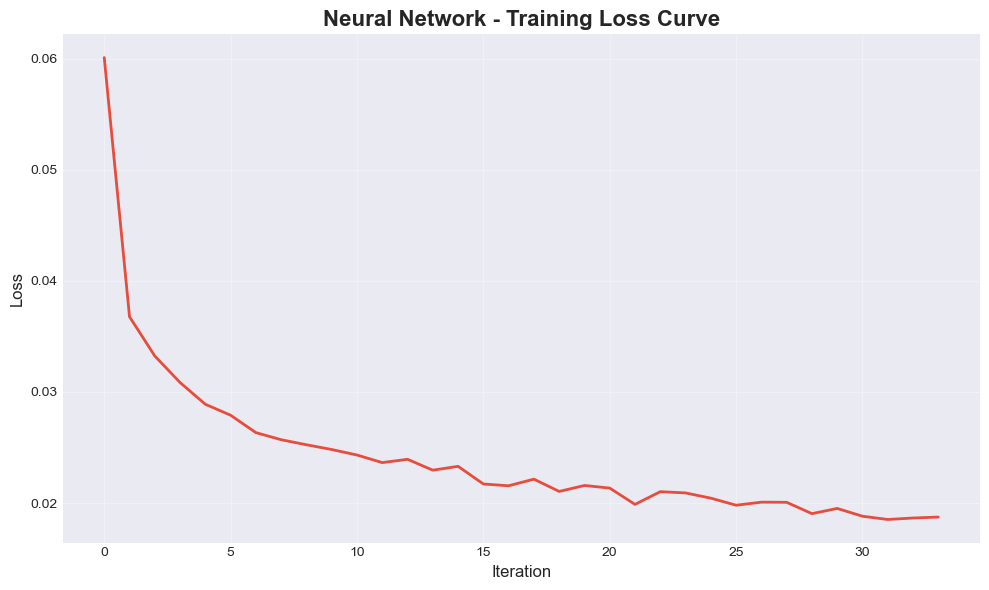

✓ Saved: nn_training_loss.png


In [29]:
if hasattr(nn_model, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(nn_model.loss_curve_, linewidth=2, color='#e74c3c')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Neural Network - Training Loss Curve', fontsize=16, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('nn_training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✓ Saved: nn_training_loss.png')
else:
    print('⚠️  Loss curve not available')

#### 5.4.5 Save Model

In [30]:
nn_package = {
    'model': nn_model,
    'model_name': 'Neural Network Binary Classifier',
    'scaler': scaler,
    'label_encoder': label_encoder,
    'label_names': label_encoder.classes_.tolist(),
    'feature_names': X.columns.tolist(),
    'test_accuracy': nn_test_acc,
    'test_f1': nn_test_f1,
    'scaling_required': True,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'binary',
    'cv_results': nn_cv_results
}

with open(f'{model_folder}/neural_network_binary.pkl', 'wb') as f:
    pickle.dump(nn_package, f)

print(f'✓ Saved: {model_folder}/neural_network_binary.pkl')

✓ Saved: new_models/neural_network_binary.pkl


## 6. Model Evaluation

### 6.1 Detailed Metrics

In [31]:
models_dict = {
    'Random Forest': (rf_test_pred, rf_test_proba),
    'Logistic Regression': (lr_test_pred, lr_test_proba),
    'Neural Network': (nn_test_pred, nn_test_proba)
}

all_metrics = []

for model_name, (y_pred, y_proba) in models_dict.items():
    print(f'\n{"="*70}')
    print(f'{model_name.upper()}')
    print('='*70)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'\nTest Set Metrics:')
    print(f'  Accuracy:  {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall:    {recall:.4f}')
    print(f'  F1 Score:  {f1:.4f}')
    
    # Per-class metrics
    print(f'\nPer-Class Metrics:')
    print(classification_report(y_test, y_pred, 
                                target_names=label_encoder.classes_,
                                digits=4))
    
    all_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })


RANDOM FOREST

Test Set Metrics:
  Accuracy:  0.9996
  Precision: 0.9996
  Recall:    0.9996
  F1 Score:  0.9996

Per-Class Metrics:
              precision    recall  f1-score   support

      ATTACK     0.9993    0.9998    0.9996     59364
      BENIGN     0.9998    0.9993    0.9996     59364

    accuracy                         0.9996    118728
   macro avg     0.9996    0.9996    0.9996    118728
weighted avg     0.9996    0.9996    0.9996    118728


LOGISTIC REGRESSION

Test Set Metrics:
  Accuracy:  0.9405
  Precision: 0.9408
  Recall:    0.9405
  F1 Score:  0.9405

Per-Class Metrics:
              precision    recall  f1-score   support

      ATTACK     0.9309    0.9517    0.9412     59364
      BENIGN     0.9506    0.9294    0.9399     59364

    accuracy                         0.9405    118728
   macro avg     0.9408    0.9405    0.9405    118728
weighted avg     0.9408    0.9405    0.9405    118728


NEURAL NETWORK

Test Set Metrics:
  Accuracy:  0.9946
  Precision: 0.99

### 6.2 Confusion Matrices

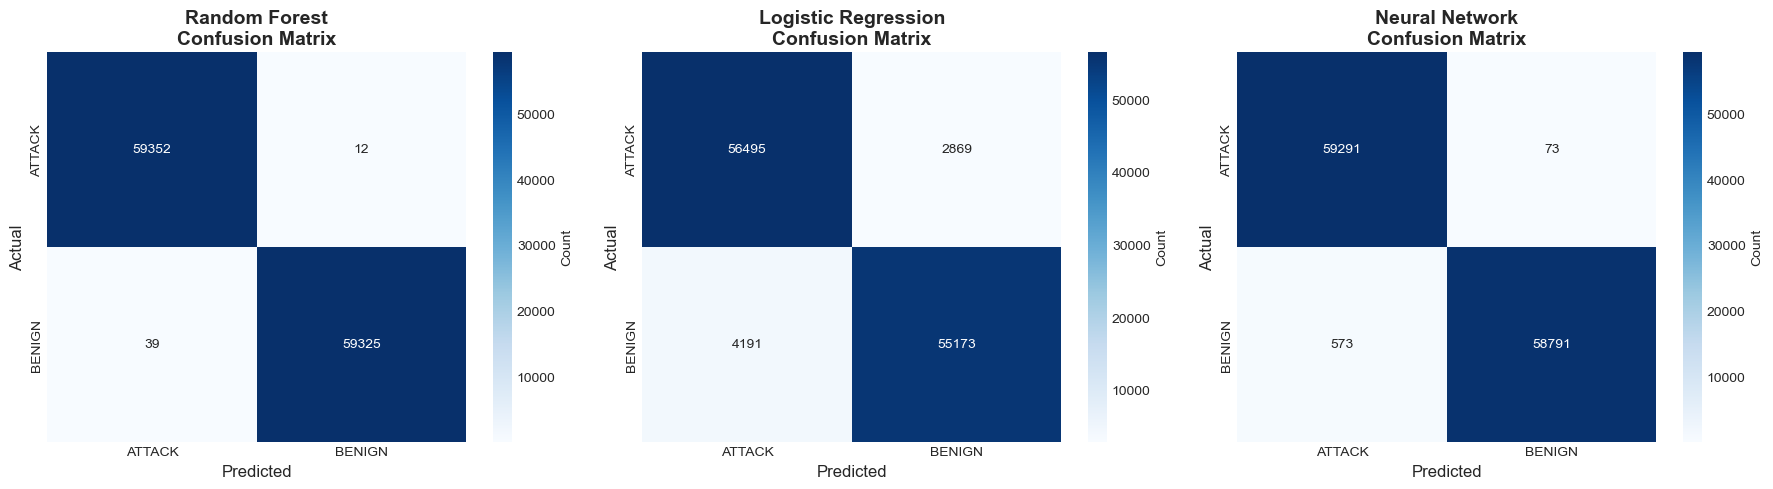

✓ Saved: confusion_matrices.png


In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, (y_pred, y_proba)) in enumerate(models_dict.items()):
    ax = axes[idx]
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print('✓ Saved: confusion_matrices.png')

### 6.3 ROC Curves

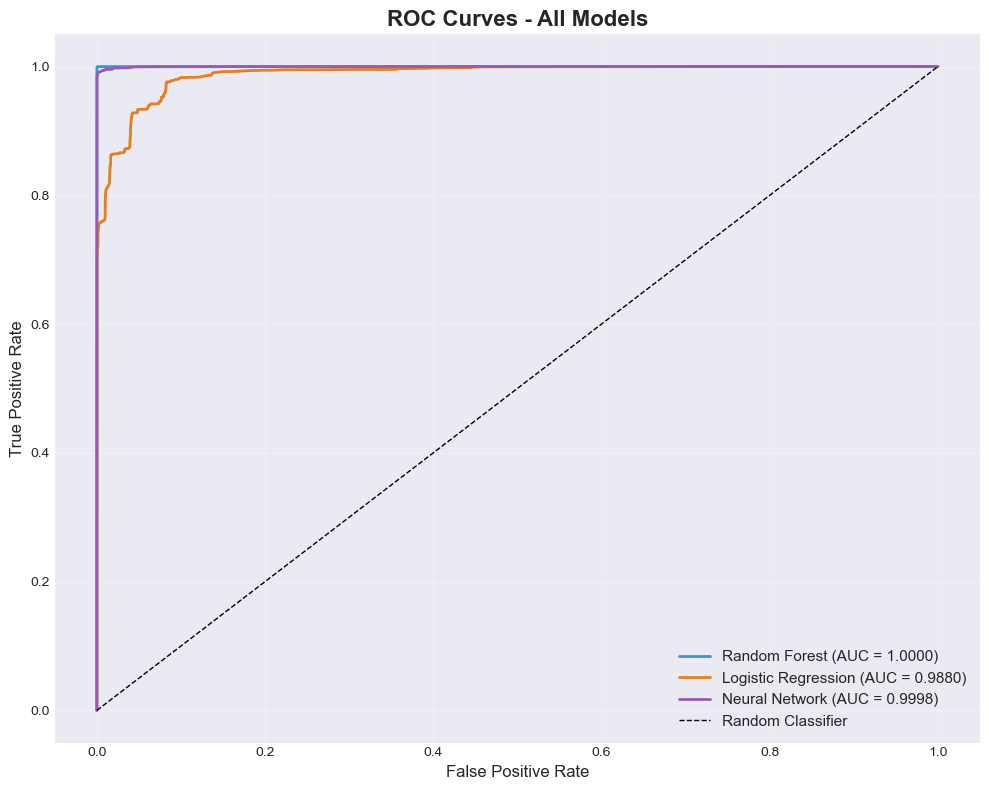

✓ Saved: roc_curves.png


In [33]:
plt.figure(figsize=(10, 8))

colors_roc = ['#3498db', '#e67e22', '#9b59b6']

for idx, (model_name, (y_pred, y_proba)) in enumerate(models_dict.items()):
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors_roc[idx], linewidth=2,
             label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print('✓ Saved: roc_curves.png')

### 6.4 Precision-Recall Curves

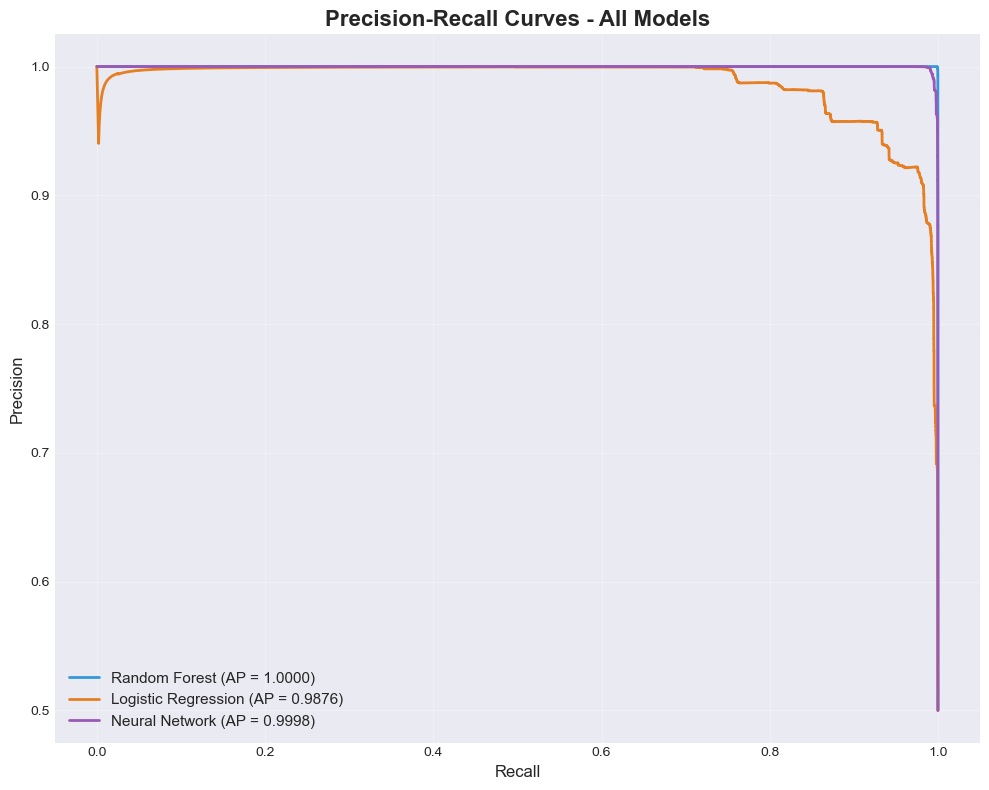

✓ Saved: precision_recall_curves.png


In [34]:
plt.figure(figsize=(10, 8))

for idx, (model_name, (y_pred, y_proba)) in enumerate(models_dict.items()):
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba[:, 1])
    avg_precision = average_precision_score(y_test, y_proba[:, 1])
    
    plt.plot(recall_curve, precision_curve, color=colors_roc[idx], linewidth=2,
             label=f'{model_name} (AP = {avg_precision:.4f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower left', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print('✓ Saved: precision_recall_curves.png')

## 7. Model Comparison

### 7.1 Performance Comparison Table

In [35]:
comparison_df = pd.DataFrame(model_results)

print('='*70)
print('FINAL MODEL COMPARISON')
print('='*70)
print('\n📊 Complete Performance Metrics:')
print(comparison_df.to_string(index=False))

# Find best model
best_test_acc_idx = comparison_df['test_acc'].idxmax()
best_test_f1_idx = comparison_df['test_f1'].idxmax()

print(f'\n🏆 Best Model by Test Accuracy: {comparison_df.loc[best_test_acc_idx, "model"]}')
print(f'   Accuracy: {comparison_df.loc[best_test_acc_idx, "test_acc"]:.4f}')

print(f'\n🏆 Best Model by Test F1 Score: {comparison_df.loc[best_test_f1_idx, "model"]}')
print(f'   F1 Score: {comparison_df.loc[best_test_f1_idx, "test_f1"]:.4f}')

FINAL MODEL COMPARISON

📊 Complete Performance Metrics:
              model  train_acc  val_acc  test_acc  train_f1   val_f1  test_f1  cv_acc_mean  cv_acc_std  training_time
      Random Forest   0.999783 0.999520  0.999570  0.999783 0.999520 0.999570          NaN         NaN      73.856951
Logistic Regression   0.940850 0.940764  0.940536  0.940843 0.940756 0.940529     0.940444    0.000830     991.446360
     Neural Network   0.994533 0.993986  0.994559  0.994533 0.993986 0.994559     0.994329    0.000993     311.606905

🏆 Best Model by Test Accuracy: Random Forest
   Accuracy: 0.9996

🏆 Best Model by Test F1 Score: Random Forest
   F1 Score: 0.9996


### 7.2 Visual Comparison

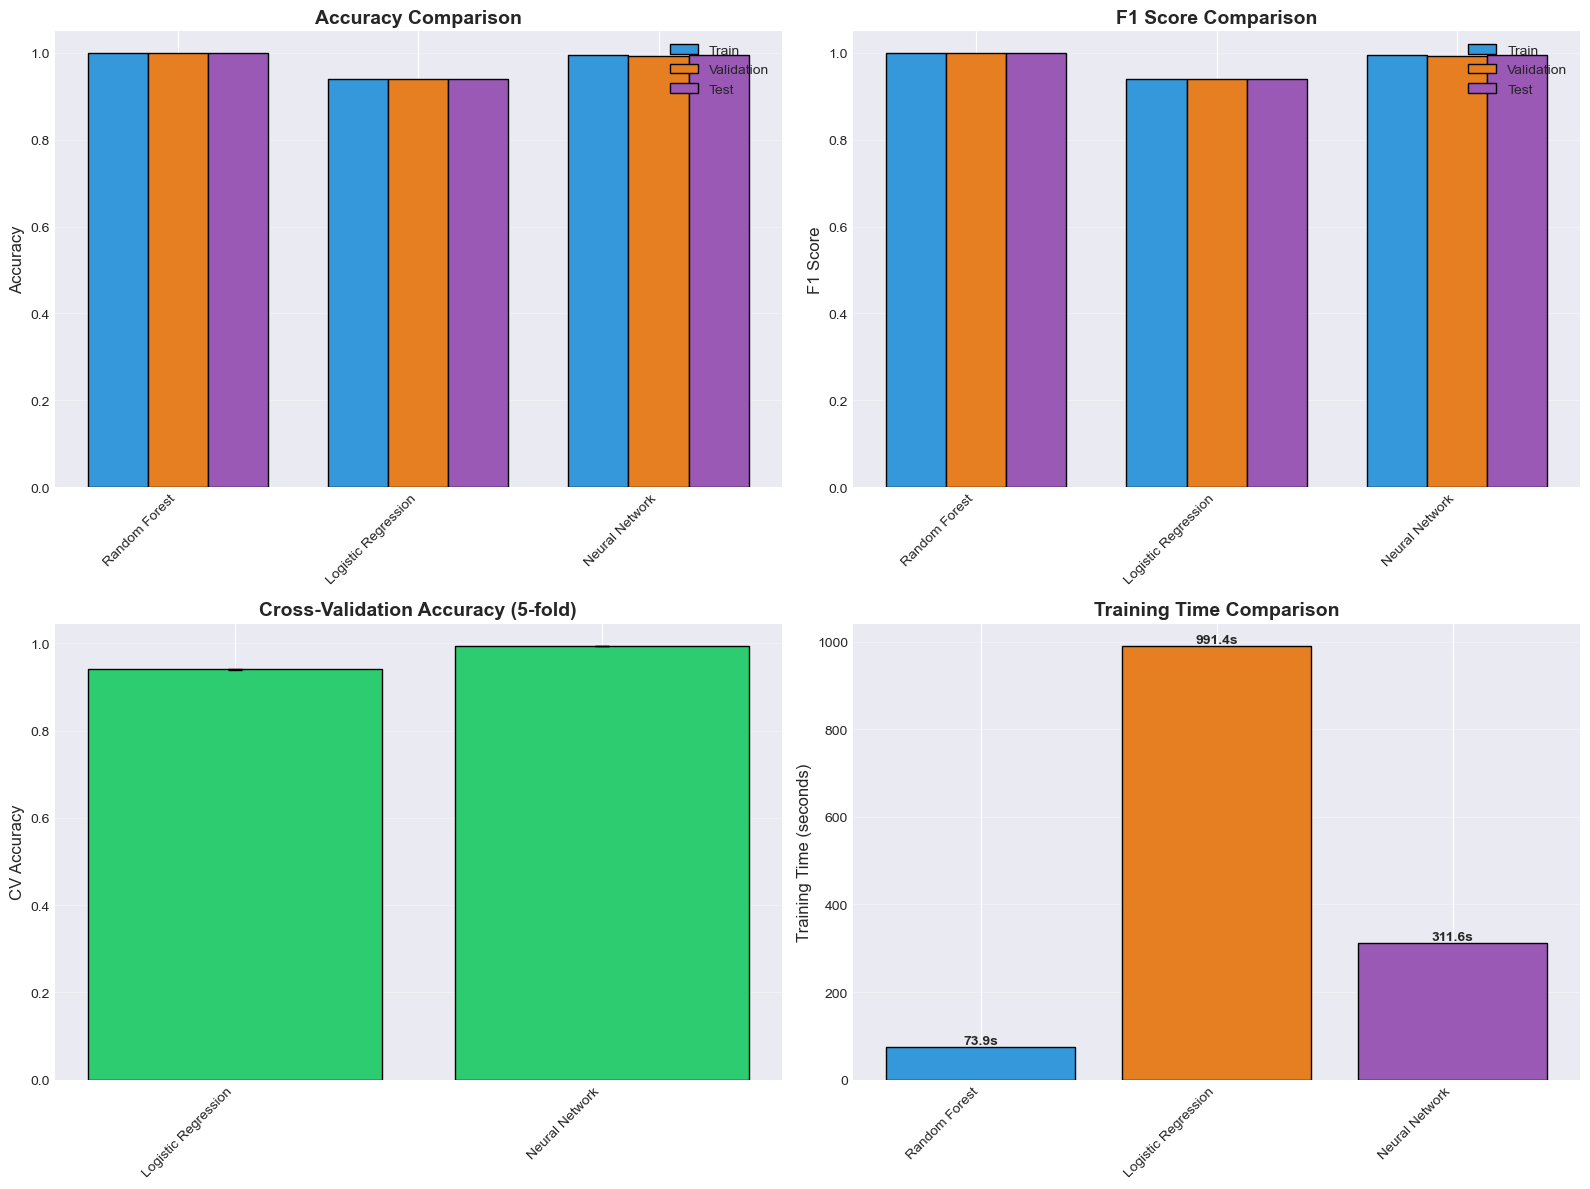

✓ Saved: model_comparison.png


In [36]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_list = comparison_df['model'].values
x_pos = np.arange(len(models_list))
width = 0.25

# Accuracy comparison
ax1 = axes[0, 0]
ax1.bar(x_pos - width, comparison_df['train_acc'], width, label='Train', color='#3498db', edgecolor='black')
ax1.bar(x_pos, comparison_df['val_acc'], width, label='Validation', color='#e67e22', edgecolor='black')
ax1.bar(x_pos + width, comparison_df['test_acc'], width, label='Test', color='#9b59b6', edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_list, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# F1 Score comparison
ax2 = axes[0, 1]
ax2.bar(x_pos - width, comparison_df['train_f1'], width, label='Train', color='#3498db', edgecolor='black')
ax2.bar(x_pos, comparison_df['val_f1'], width, label='Validation', color='#e67e22', edgecolor='black')
ax2.bar(x_pos + width, comparison_df['test_f1'], width, label='Test', color='#9b59b6', edgecolor='black')
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models_list, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Cross-validation scores
ax3 = axes[1, 0]
ax3.bar(models_list, comparison_df['cv_acc_mean'], color='#2ecc71', edgecolor='black')
ax3.errorbar(models_list, comparison_df['cv_acc_mean'],
             yerr=comparison_df['cv_acc_std'],
             fmt='none', color='black', capsize=5, linewidth=2)
ax3.set_ylabel('CV Accuracy', fontsize=12)
ax3.set_title('Cross-Validation Accuracy (5-fold)', fontsize=14, fontweight='bold')
ax3.set_xticklabels(models_list, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Training time
ax4 = axes[1, 1]
colors_time = ['#3498db', '#e67e22', '#9b59b6']
bars = ax4.bar(models_list, comparison_df['training_time'], color=colors_time, edgecolor='black')
ax4.set_ylabel('Training Time (seconds)', fontsize=12)
ax4.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax4.set_xticklabels(models_list, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print('✓ Saved: model_comparison.png')

### 7.3 Save Best Model

In [37]:
import shutil

# Determine best model
best_idx = comparison_df['test_f1'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'model']

print(f'🏆 Best Model: {best_model_name}')
print(f'   Test Accuracy: {comparison_df.loc[best_idx, "test_acc"]:.4f}')
print(f'   Test F1 Score: {comparison_df.loc[best_idx, "test_f1"]:.4f}')

# Copy best model
if best_model_name == 'Random Forest':
    source = f'{model_folder}/random_forest_binary.pkl'
elif best_model_name == 'Logistic Regression':
    source = f'{model_folder}/logistic_regression_binary.pkl'
else:
    source = f'{model_folder}/neural_network_binary.pkl'

dest = f'{model_folder}/best_ids_model.pkl'
shutil.copy(source, dest)
print(f'✓ Best model copied to: {dest}')

# Save comparison table
comparison_df.to_csv(f'{model_folder}/model_comparison.csv', index=False)
print(f'✓ Comparison table saved: {model_folder}/model_comparison.csv')

🏆 Best Model: Random Forest
   Test Accuracy: 0.9996
   Test F1 Score: 0.9996
✓ Best model copied to: new_models/best_ids_model.pkl
✓ Comparison table saved: new_models/model_comparison.csv


### 7.4 Final Summary

In [38]:
summary = f"""
{'='*70}
TRAINING COMPLETE!
{'='*70}

Dataset: {len(df_balanced):,} samples
  Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}
  Features: {X.shape[1]} | Classes: 2 (BENIGN, ATTACK)

Best Model: {best_model_name}
  Test Accuracy: {comparison_df.loc[best_idx, 'test_acc']:.4f}
  Test F1 Score: {comparison_df.loc[best_idx, 'test_f1']:.4f}

Files Saved:
  Models: {model_folder}/
    - random_forest_binary.pkl
    - logistic_regression_binary.pkl
    - neural_network_binary.pkl
    - best_ids_model.pkl (DEPLOY THIS!)
  
  Visualizations:
    - binary_label_distribution.png
    - correlation_heatmap.png
    - data_split_visualization.png
    - rf_feature_importance.png
    - lr_feature_coefficients.png
    - nn_training_loss.png
    - confusion_matrices.png
    - roc_curves.png
    - precision_recall_curves.png
    - model_comparison.png

{'='*70}
✅ Ready for deployment!
{'='*70}
"""

print(summary)

# Save summary
with open(f'{model_folder}/training_summary.txt', 'w') as f:
    f.write(summary)

print(f'✓ Summary saved: {model_folder}/training_summary.txt')


TRAINING COMPLETE!

Dataset: 791,520 samples
  Train: 554,064 | Val: 118,728 | Test: 118,728
  Features: 78 | Classes: 2 (BENIGN, ATTACK)

Best Model: Random Forest
  Test Accuracy: 0.9996
  Test F1 Score: 0.9996

Files Saved:
  Models: new_models/
    - random_forest_binary.pkl
    - logistic_regression_binary.pkl
    - neural_network_binary.pkl
    - best_ids_model.pkl (DEPLOY THIS!)
  
  Visualizations:
    - binary_label_distribution.png
    - correlation_heatmap.png
    - data_split_visualization.png
    - rf_feature_importance.png
    - lr_feature_coefficients.png
    - nn_training_loss.png
    - confusion_matrices.png
    - roc_curves.png
    - precision_recall_curves.png
    - model_comparison.png

✅ Ready for deployment!



UnicodeEncodeError: 'charmap' codec can't encode character '\u2705' in position 963: character maps to <undefined>

## 🎉 Training Complete!

### Your IDS model is ready for deployment!

**Next Steps:**
1. Review all visualizations
2. Check model_comparison.csv for detailed metrics
3. Upload `new_models/best_ids_model.pkl` to Hugging Face
4. Deploy and test!

**Expected Performance: 95-99% accuracy** ✅